In [98]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.pylab import rcParams

# import data
data = pd.read_csv('/Users/Developer/Documents/cse391/cancer_project_cse391/data/Cancer_Data.txt', sep="\t", header=None, low_memory = False)

# create data frame
df = pd.DataFrame(data)

# get columns labels
columns = df.iloc[0, 1:]

# index labels
index = df.iloc[17:,0]

# get actual data
data1 = df.iloc[17:,1:]

#set index labels to data
data1.index = index

# set column lables to data
data1.columns = columns

# data preprocessing
data1 = data1.dropna()

In [99]:
# generate random sample by getting random indexes for patient ids and genes 
patient_indexes = np.random.randint(0,len(data1.columns), 50)
gene_indexes = np.random.randint(0, len(data1), 2000)

# extract sample data from indexes
sample_data = data1.iloc[gene_indexes, patient_indexes]

In [100]:
# Applying k-means to cancer sample data
kmeans = KMeans(n_clusters=20, init= 'k-means++')
y_kmeans = kmeans.fit_predict(sample_data)

#number of genes in each cluster
num_genes = pd.DataFrame(np.bincount(y_kmeans), index=np.arange(1,21), columns = ["Number of Genes"])
display(num_genes.describe())
display(num_genes)

,Number of Genes
count,20.000000
mean,100.000000
std,65.506127
min,15.000000
25%,41.500000
50%,81.500000
75%,157.500000
max,197.000000


,Number of Genes
1,194
2,106
3,99
4,152
5,15
6,190
7,139
8,192
9,37
10,134


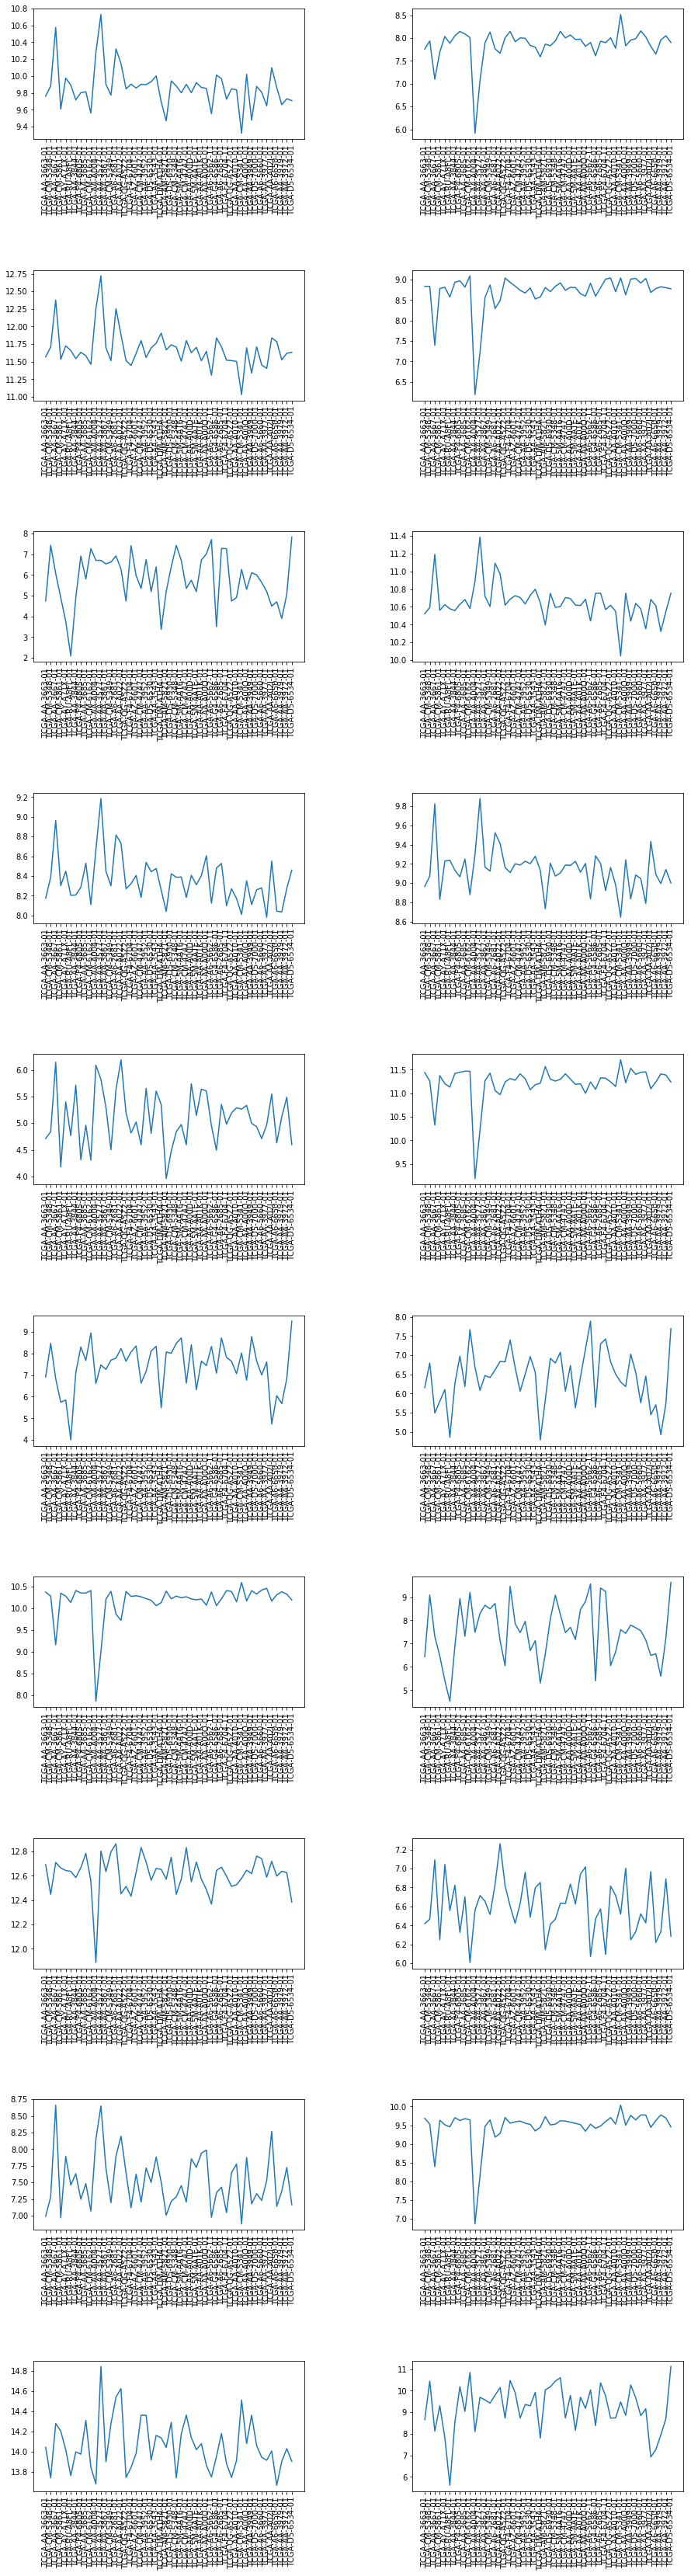

In [101]:
rcParams['figure.figsize'] = 15, 60
plt.subplots_adjust(top = 0.75, bottom=0.01, hspace=1.0, wspace=0.4)
centers = kmeans.cluster_centers_
for c in range(20):
    plt.subplot(10,2,c+1)
    plt.xticks(np.arange(50), sample_data.columns, rotation = 'vertical')
    plt.plot(centers[c])
plt.show()

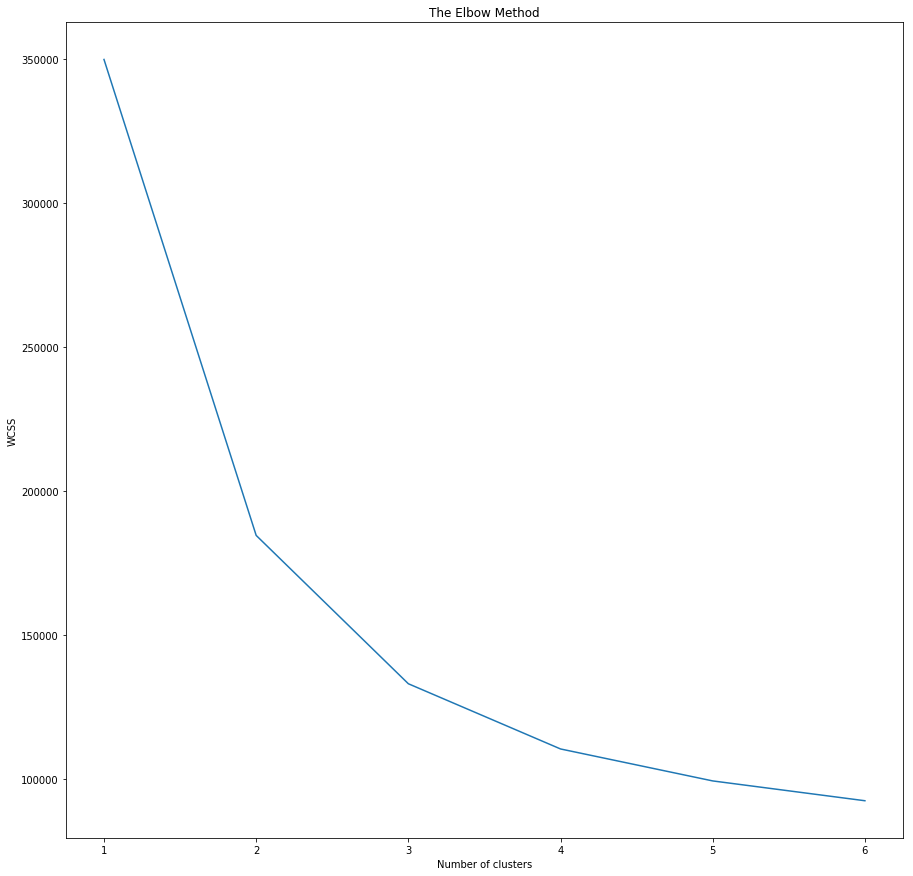

In [102]:
rcParams['figure.figsize'] = 15, 15
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 7):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(sample_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,7),wcss)

plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Using the elbow method we find that the optimal number of clusters is 4. The decrease in the wcss is significantly smaller after 4. We should decrease the number of clusters as we only need 4.

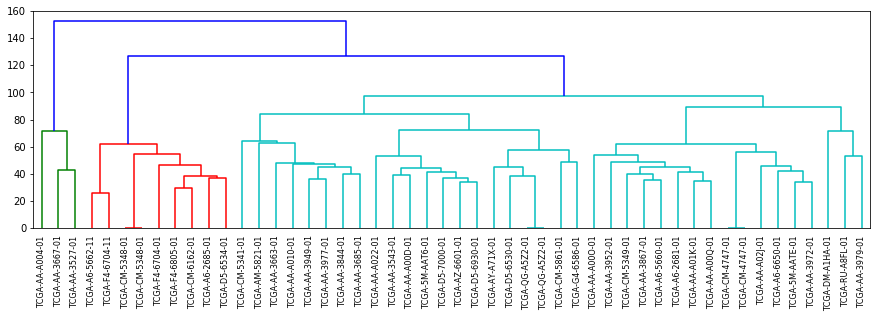

In [103]:
# Fitting Hierarcical clustering to the sample data
import scipy.cluster.hierarchy as sch
rcParams['figure.figsize'] = 15, 4
dendrogram = sch.dendrogram(sch.linkage(sample_data.T, method = 'ward'), labels=sample_data.columns)
plt.show()

The number of dominant clusters is 3.

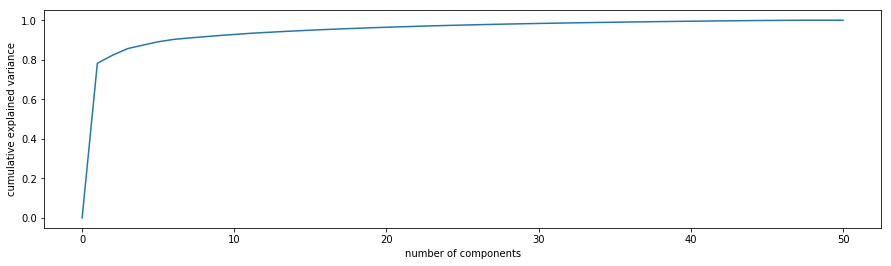

,Cumulative Explained Variance
1,0.782052
2,0.823192
3,0.856666
4,0.874182
5,0.891096
6,0.902889
7,0.910174
8,0.916388
9,0.922571
10,0.928133


In [104]:
# PERFORM PCA
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(sample_data)
explained_variance = pca.explained_variance_ratio_
arr = np.insert(np.cumsum(explained_variance),0,0)
plt.plot(arr)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()
display(pd.DataFrame(np.cumsum(explained_variance), index=np.arange(1,51), 
                     columns=['Cumulative Explained Variance']).head(15))

If we want to explain 90% of the variation in the data we would need 6 principal components. If we wish to explain 95% of the data we would need 15 principal components

In [105]:
import scipy.io
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import itertools
mat = scipy.io.loadmat('/Users/Developer/Documents/cse391/cancer_project_cse391/data/CSE391_classificatin_project.mat')
X = pd.DataFrame(mat.get('X'))
Y = pd.DataFrame(mat.get('Y'))
X = X.T
Y = Y.T
X['class'] = 0
Y['class'] = 1

In [106]:
X_features = X.iloc[:, :-1]
X_class = X.iloc[:,-1]
# Split the data into a training set and a test set
X_train, X_test, X_class_train, X_class_test = train_test_split(
    X_features, X_class, test_size = .2)

Y_features = Y.iloc[:, :-1]
Y_class = Y.iloc[:,-1]
Y_train, Y_test, Y_class_train, Y_class_test = train_test_split(Y_features, Y_class, test_size = .2, random_state=0)
# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results

x_final_train = pd.concat([X_train,Y_train],ignore_index=True)
y_final_train = pd.concat([X_class_train,Y_class_train],ignore_index=True)
x_final_test = pd.concat([X_test,Y_test],ignore_index=True)
y_final_test = pd.concat([X_class_test,Y_class_test],ignore_index=True)

classifier = svm.SVC(kernel = "linear")
y_final_pred = classifier.fit(x_final_train, y_final_train).predict(x_final_test)

Confusion matrix, without normalization
[[50  0]
 [ 0 50]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


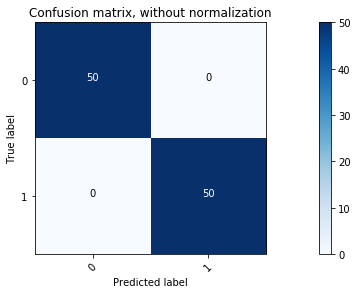

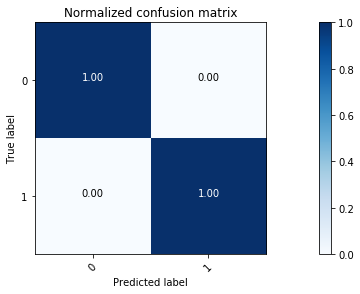

In [107]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_final_test, y_final_pred)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['0','1']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()